### Doesnt work with longer audios

In [1]:
# """
# You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
# TitaNet: https://arxiv.org/pdf/2110.04410.pdf

# Instructions for setting up Colab are as follows:
# 1. Open a new Python 3 notebook.
# 2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
# 3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
# 4. Run this cell to set up dependencies.
# """
# # If you're using Google Colab and not running locally, run this cell.

# ## Install dependencies
# !pip install wget
# !apt-get install sox libsndfile1 ffmpeg
# !pip install unidecode

# # ## Install NeMo
# BRANCH = 'main'
# !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[asr]

# ## Install TorchAudio
# !pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html


In [2]:
import os
import torch
print (os.environ['CONDA_DEFAULT_ENV'])
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
# CUDA_VISIBLE_DEVICES options = 0/1/2/3. Make sure to restart
!echo $CUDA_VISIBLE_DEVICES
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
device

base



device(type='cpu')

In [3]:
import os
import wget
from pydub import AudioSegment

ROOT = os.getcwd()
data_dir = os.path.join(ROOT,'data')
os.makedirs(data_dir, exist_ok=True)

# audio_uri = '20220405_1746_919580755892_12220504'
# audio_file = '20220405_1746_919580755892_12220504.mp3'
audio_uri = 'an4_diarize_test'
audio_file = 'an4_diarize_test.wav'
audio_file = os.path.join(data_dir, audio_file)
audio_uri = os.path.join(data_dir, audio_uri)

# ami_rttm_file = 'MixHeadset.test.rttm' #  loads a dictionary
# ami_rttm = os.path.join(data_dir, ami_rttm_file)

if not os.path.exists(audio_file):
    print("Check input path file name. No such file in ", os.getcwd())
if audio_file.endswith('.mp3'):
    # convert mp3 file to wav file
    sound = AudioSegment.from_mp3(audio_file)
    audio_file = audio_uri + '.wav'
    sound.export(audio_file, format="wav")    

print("Using audio: ",audio_file)
!ls


Using audio:  /home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/an4_diarize_test.wav
 20220405_1746_919580755892_12220504.wav    data
'NeMo SD train.ipynb'			    manifest_vad_input.json
'NeMo SD train.py'			   'nemo-audio only.ipynb'
'NeMo-AMI Benchmark(15).ipynb'		    nemo_experiments
'NeMo-VoxConverse Benchmark DER(9).ipynb'   oracle_vad
 Speaker_Diarization_Inference-NeMo.ipynb   outputs
 conf					    scripts


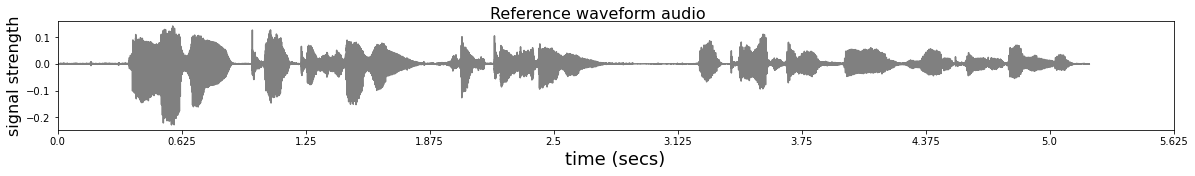

In [4]:
# plot and see the wave
import matplotlib.pyplot as plt
import numpy as np
import librosa

sr = 16000
signal, sr = librosa.load(audio_file,sr=sr) 

# plot and listen to the audio and visualize the RTTM speaker labels
fig,ax = plt.subplots(1,1)
fig.set_figwidth(20)
fig.set_figheight(2)
plt.plot(np.arange(len(signal)),signal,'gray')
fig.suptitle('Reference waveform audio', fontsize=16)
plt.xlabel('time (secs)', fontsize=18)
ax.margins(x=0)
plt.ylabel('signal strength', fontsize=16);
a,_ = plt.xticks();plt.xticks(a,a/sr);
plt.show()


In [5]:
import torchaudio
from IPython.display import display, Audio

def correct_sample_rate(audio_path, show_display=False):
    """
    Corrects the sample rate and channels of audio.
    Display shows audio file but takes time to load
    
    SAMPLE_RATE = 16000
    """
    SAMPLE_RATE = 16000
    waveform, sr = torchaudio.load(audio_path)
    metadata = torchaudio.info(audio_path)

    print(metadata)

    waveform = waveform.mean(dim=0) # if there are multiple channels, average them to single channel
    waveform = waveform.reshape(1, waveform.shape[0])
    if sr != SAMPLE_RATE:
        resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE)
        waveform_resampled = resampler(waveform)
        waveform = waveform_resampled

    torchaudio.save(audio_path, waveform, SAMPLE_RATE, bits_per_sample=16, encoding="PCM_S")

    metadata = torchaudio.info(audio_path)
    if show_display:
        # TODO: display_waveform(signal)
        print(f"SR: {SAMPLE_RATE}Hz, {waveform}")
        print("Metadata: ", metadata)
        display(Audio(audio_path,rate=SAMPLE_RATE, autoplay=True))


        
## RUN ONLY ONCE! Convert rttm to same AMI base name
# convert_ami_base()

## Display audio only for visualisation
correct_sample_rate(audio_path=audio_file, show_display=False)

AudioMetaData(sample_rate=16000, num_frames=83200, num_channels=1, bits_per_sample=16, encoding=PCM_S)


We would use [pyannote_metrics](https://pyannote.github.io/pyannote-metrics/) for visualization and score calculation purposes. Hence all the labels in rttm formats would eventually be converted to pyannote objects, we created two helper functions rttm_to_labels (for NeMo intermediate processing) and labels_to_pyannote_object for scoring and visualization format

In [6]:
# TAKES A LOT OF TIME. RUN ONLY FOR VISUALISATION

display(Audio(audio_file, rate=16000, autoplay=True))

In [7]:
# since for evaluation we use pyannote.metrics, convert rttm formats to pyannote Annotation objects
from nemo.collections.asr.parts.utils.speaker_utils import rttm_to_labels, labels_to_pyannote_object

# view the sample groundtruth rttm file
# !cat {ami_rttm}

/root/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
[NeMo W 2022-07-25 20:20:33 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.


In [8]:
# labels = rttm_to_labels(ami_rttm)
# groundtruth = labels_to_pyannote_object(labels)

# # to see the labels of each speaker and time intervals
# # print(labels)
# groundtruth

Speaker Diarization scripts commonly expects following arguments:
1. manifest_filepath : Path to manifest file containing json lines of format: {'audio_filepath': /path/to/audio_file, 'offset': 0, 'duration':None, 'label': 'infer', 'text': '-', 'num_speakers': None, 'rttm_filepath': /path/to/rttm/file, 'uem_filepath'='/path/to/uem/filepath'}
2. out_dir : directory where outputs and intermediate files are stored. 
3. oracle_vad: If this is true then we extract speech activity labels from rttm files, if False then either 
4. vad.model_path or external_manifestpath containing speech activity labels has to be passed. 

Mandatory fields are audio_filepath, offset, duration, label and text. For the rest if you would like to evaluate with known number of speakers pass the value else None. If you would like to score the system with known rttms then that should be passed as well, else None. uem file is used to score only part of your audio for evaluation purposes, hence pass if you would like to evaluate on it else None.


**Note** we expect audio and corresponding RTTM have **same base name** and the name should be **unique**. 

For eg: if audio file name is **test_an4**.wav, if provided we expect corresponding rttm file name to be **test_an4**.rttm (note the matching **test_an4** base name)


Lets create manifest with the an4 audio and rttm available. If you have more than one files you may also use the script `pathfiles_to_diarize_manifest.py` to generate manifest file from list of audio files and optionally rttm files 

In [9]:
# Create a manifest for input with below format. 
# {'audio_filepath': /path/to/audio_file, 'offset': 0, 'duration':None, 'label': 'infer', 'text': '-', 
# 'num_speakers': None, 'rttm_filepath': /path/to/rttm/file, 'uem_filepath'='/path/to/uem/filepath'}
import json
meta = {
    'audio_filepath': audio_file, 
    'offset': 0, 
    'duration':None, 
    'label': 'infer', 
    'text': '-', 
    'num_speakers': 2, 
    'rttm_filepath': None, 
    'uem_filepath' : None
}
with open('data/input_manifest.json','w') as fp:
    json.dump(meta,fp)
    fp.write('\n')

!cat data/input_manifest.json

output_dir = os.path.join(ROOT, 'oracle_vad')
os.makedirs(output_dir,exist_ok=True)

{"audio_filepath": "/home/DATA/amit_kesari/SD1/NeMo-Nvidia/data/an4_diarize_test.wav", "offset": 0, "duration": null, "label": "infer", "text": "-", "num_speakers": 2, "rttm_filepath": null, "uem_filepath": null}


In [10]:
from omegaconf import OmegaConf
MODEL_CONFIG = os.path.join(data_dir,'offline_diarization.yaml')
if not os.path.exists(MODEL_CONFIG):
    config_url = "https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/speaker_tasks/diarization/conf/offline_diarization.yaml"
    MODEL_CONFIG = wget.download(config_url,data_dir)

config = OmegaConf.load(MODEL_CONFIG)
print(OmegaConf.to_yaml(config))

name: ClusterDiarizer
num_workers: 4
sample_rate: 16000
batch_size: 64
diarizer:
  manifest_filepath: ???
  out_dir: ???
  oracle_vad: false
  collar: 0.25
  ignore_overlap: true
  vad:
    model_path: null
    external_vad_manifest: null
    parameters:
      window_length_in_sec: 0.15
      shift_length_in_sec: 0.01
      smoothing: median
      overlap: 0.875
      onset: 0.4
      offset: 0.7
      pad_onset: 0.05
      pad_offset: -0.1
      min_duration_on: 0.2
      min_duration_off: 0.2
      filter_speech_first: true
  speaker_embeddings:
    model_path: ???
    parameters:
      window_length_in_sec: 1.5
      shift_length_in_sec: 0.75
      multiscale_weights: null
      save_embeddings: false
  clustering:
    parameters:
      oracle_num_speakers: false
      max_num_speakers: 20
      enhanced_count_thres: 80
      max_rp_threshold: 0.25
      sparse_search_volume: 30



# VAD DIARIZATION

In this method we compute VAD time stamps using NeMo VAD model on input manifest file and then use these time stamps of speech label to find speaker embeddings followed by clustering them into num of speakers

In [11]:
output_dir = os.path.join(ROOT,'outputs')
config.diarizer.manifest_filepath = 'data/input_manifest.json'
config.diarizer.out_dir = output_dir #Directory to store intermediate files and prediction outputs

pretrained_vad = 'vad_marblenet'
pretrained_speaker_model = 'titanet_large'

config.batch_size: 8
config.diarizer.speaker_embeddings.model_path = pretrained_speaker_model
config.diarizer.speaker_embeddings.parameters.window_length_in_sec = 1.5
config.diarizer.speaker_embeddings.parameters.shift_length_in_sec = 0.75
config.diarizer.oracle_vad = False # compute VAD provided with model_path to vad config
config.diarizer.clustering.parameters.oracle_num_speakers=True
# change to False for no speaker count

#Here we use our inhouse pretrained NeMo VAD 
config.diarizer.vad.model_path = pretrained_vad
config.diarizer.vad.window_length_in_sec = 0.15
config.diarizer.vad.shift_length_in_sec = 0.01
config.diarizer.vad.parameters.onset = 0.8 
config.diarizer.vad.parameters.offset = 0.6
config.diarizer.vad.parameters.min_duration_on = 0.1
config.diarizer.vad.parameters.min_duration_off = 0.4

Now that we passed all the variables we needed lets initialize the clustering model with above config

In [12]:
from nemo.collections.asr.models import ClusteringDiarizer
sd_model = ClusteringDiarizer(cfg=config)

[NeMo I 2022-07-25 20:20:54 clustering_diarizer:129] Loading pretrained vad_marblenet model from NGC
[NeMo I 2022-07-25 20:20:54 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/vad_marblenet/10477085f32c378938ef41e65dc2e1b3/vad_marblenet.nemo.
[NeMo I 2022-07-25 20:20:54 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/vad_marblenet/10477085f32c378938ef41e65dc2e1b3/vad_marblenet.nemo
[NeMo I 2022-07-25 20:20:54 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:20:55 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    vad_stream: false
    manifest_filepath: /home/fjia/code/manifest64/train.json
    sample_rate: 16000
    labels:
    - background
    - speech
    batch_size: 128
    num_workers: 20
    shuffle: true
    augmentor:
      shift:
        prob: 0.8
        min_shift_ms: -5.0
        max_shift_ms: 5.0
      white_noise:
        prob: 0.8
        min_level: -90
        max_level: -46
    
[NeMo W 2022-07-25 20:20:55 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    vad_stream: false
    manifest_filepath: /home/fjia/code/manifest64/validation.json
    sample_r

[NeMo I 2022-07-25 20:20:55 save_restore_connector:243] Model EncDecClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/vad_marblenet/10477085f32c378938ef41e65dc2e1b3/vad_marblenet.nemo.
[NeMo I 2022-07-25 20:20:55 clustering_diarizer:153] Loading pretrained titanet_large model from NGC
[NeMo I 2022-07-25 20:20:55 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2022-07-25 20:20:55 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2022-07-25 20:20:55 common:789] Instantiating model from pre-trained checkpoint


[NeMo W 2022-07-25 20:20:56 modelPT:148] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2022-07-25 20:20:56 modelPT:155] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2022-07-25 20:20:56 features:200] PADDING: 16
[NeMo I 2022-07-25 20:20:56 label_models:100] loss is Angular Softmax
[NeMo I 2022-07-25 20:20:56 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.10.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.


In [13]:
sd_model.diarize()

[NeMo I 2022-07-25 20:20:59 speaker_utils:82] Number of files to diarize: 1
[NeMo I 2022-07-25 20:20:59 clustering_diarizer:293] Split long audio file to avoid CUDA memory issue


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

[NeMo I 2022-07-25 20:21:00 vad_utils:89] The prepared manifest file exists. Overwriting!


[NeMo I 2022-07-25 20:21:00 classification_models:244] Perform streaming frame-level VAD
[NeMo I 2022-07-25 20:21:00 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:21:00 collections:293] # 1 files loaded accounting to # 1 labels


  0%|          | 0/1 [00:00<?, ?it/s][NeMo W 2022-07-25 20:21:00 nemo_logging:349] /root/anaconda3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
      warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
    
100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

[NeMo I 2022-07-25 20:21:00 clustering_diarizer:242] Generating predictions with overlapping input segments



100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


[NeMo I 2022-07-25 20:21:00 clustering_diarizer:253] Converting frame level prediction to speech/no-speech segment in start and end times format.


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

[NeMo I 2022-07-25 20:21:00 clustering_diarizer:271] Subsegmentation for embedding extraction: scale0, /home/DATA/amit_kesari/SD1/NeMo-Nvidia/outputs/speaker_outputs/subsegments_scale0.json
[NeMo I 2022-07-25 20:21:00 clustering_diarizer:325] Extracting embeddings for Diarization
[NeMo I 2022-07-25 20:21:00 collections:289] Filtered duration for loading collection is 0.000000.
[NeMo I 2022-07-25 20:21:00 collections:293] # 5 files loaded accounting to # 1 labels



100%|██████████| 1/1 [00:00<00:00,  2.62it/s]
[NeMo W 2022-07-25 20:21:01 speaker_utils:371] cuda=False, using CPU for Eigen decomposition. This might slow down the clustering process.
100%|██████████| 1/1 [00:00<00:00, 14.92it/s]
[NeMo W 2022-07-25 20:21:01 speaker_utils:469] check if each ground truth RTTMs were present in provided manifest file. Skipping calculation of Diariazation Error Rate


[NeMo I 2022-07-25 20:21:01 clustering_diarizer:444] Outputs are saved in /home/DATA/amit_kesari/SD1/NeMo-Nvidia/outputs directory


As can be seen, we first performed VAD, then with the timestamps created in `{output_dir}/vad_outputs` by VAD we calculated speaker embeddings (`{output_dir}/speaker_outputs/embeddings/`) which are then clustered using spectral clustering. 

postprocessing_params: {'window_length_in_sec': 0.15, 'shift_length_in_sec': 0.01, 'smoothing': 'median', 'overlap': 0.875, 'onset': 0.8, 'offset': 0.6, 'pad_onset': 0.05, 'pad_offset': -0.1, 'min_duration_on': 0.1, 'min_duration_off': 0.4, 'filter_speech_first': 1.0}


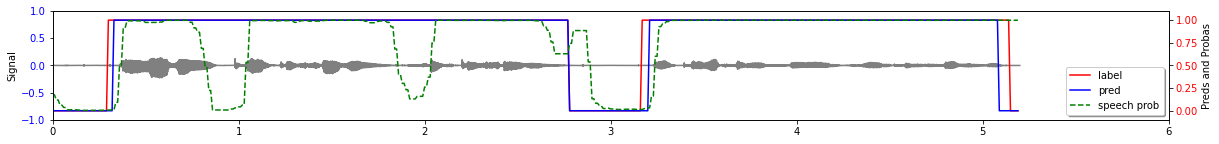

In [14]:
# VAD predicted time stamps
# you can also use single threshold(=onset=offset) for binarization and plot here
an4_rttm = os.path.join(data_dir, 'an4_diarize_test.rttm')
from nemo.collections.asr.parts.utils.vad_utils import plot
plot(
    audio_file,
    'outputs/vad_outputs/overlap_smoothing_output_median_0.875/an4_diarize_test.median', 
    an4_rttm,
    per_args = config.diarizer.vad.parameters, #threshold
    ) 

print(f"postprocessing_params: {config.diarizer.vad.parameters}")

Predicted outputs are written to `output_dir/pred_rttms` and see how we predicted along with VAD prediction

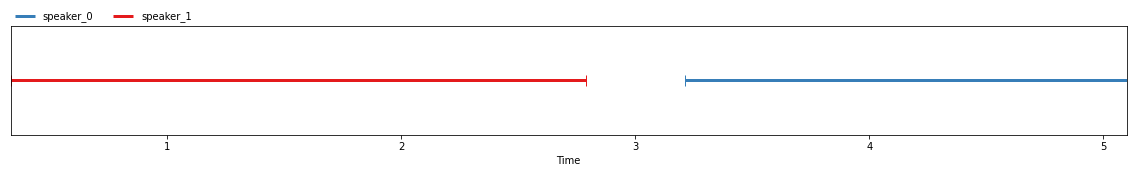

In [15]:
pred_labels = rttm_to_labels('outputs/pred_rttms/an4_diarize_test.rttm')
hypothesis = labels_to_pyannote_object(pred_labels)
hypothesis

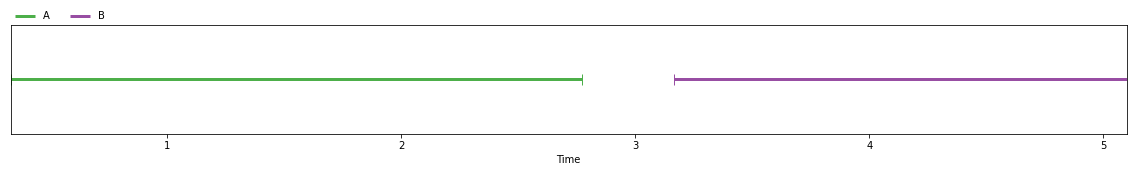

In [16]:
pred_labels = rttm_to_labels(an4_rttm)
groundtruth = labels_to_pyannote_object(pred_labels)
groundtruth

In [17]:
# DER
from pyannote.metrics.diarization import DiarizationErrorRate

metric = DiarizationErrorRate(collar=0.00)
der = metric(groundtruth, hypothesis)
print(f"Diarization error rate (DER) = {100 * der:.1f}%\n")


[NeMo W 2022-07-25 20:22:08 nemo_logging:349] /root/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
      warnings.warn(
    


Diarization error rate (DER) = 3.2%



In [18]:
!cat outputs/pred_rttms/an4_diarize_test.rttm
!cat {an4_rttm}

SPEAKER an4_diarize_test 1   0.330   2.460 <NA> <NA> speaker_1 <NA> <NA>
SPEAKER an4_diarize_test 1   3.210   1.890 <NA> <NA> speaker_0 <NA> <NA>
SPEAKER an4 1 0.298981 2.47133 <NA> <NA> A <NA>
SPEAKER an4 1 3.163901 1.98311 <NA> <NA> B <NA>


# Storing and Restoring models

Now we can save the whole config and model parameters in a single .nemo and restore from it anytime.

In [19]:
oracle_model.save_to(os.path.join(output_dir,'diarize.nemo'))

NameError: name 'oracle_model' is not defined

Restore from saved model

In [ ]:
del oracle_model
import nemo.collections.asr as nemo_asr
restored_model = nemo_asr.models.ClusteringDiarizer.restore_from(os.path.join(output_dir,'diarize.nemo'))